 <div>
 <h1><center>Applications de l'Informatique Quantique</h1>
<h2><center>Projet Noté : OPTIMISATION </h2>
<h3> Professeur: Durantin Gautier</h3>
<h4> Étudiants: Bonnet Roman, Pages Hugo </h4>
</div>
    
    

### Objectifs du notebook
    
L’établissement du don du sang se demande quels sont les critères (parmi les 4 proposés) qui 
prédisent le mieux la tendance à donner son sang ou non, afin de mettre en place des règles métier 
pour recontacter certains anciens donneurs. On cherche à éviter d’utiliser des features deux à deux 
redondantes.
    
### Imports
    
Le notebook, s'appuie sur deux librairies principales :
- *qiskit* : pour la définition des circuits quantiques et leur préparation pour l'exécution
- *qiskit_aer* : pour la simulation du comportement des ordinateurs quantiques. Le module nous permettra d'exécuter nos circuits en pratique

In [73]:
from qiskit.circuit import QuantumCircuit
from qiskit_aer.primitives import SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.circuit.library import QAOAAnsatz

from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error


from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

# 1. Visualisation des données
On commence par représenter les données afin de mieux visualiser les differentes catégories. Afin d'observer les données nous affichons les histogrammes des données fournies. 

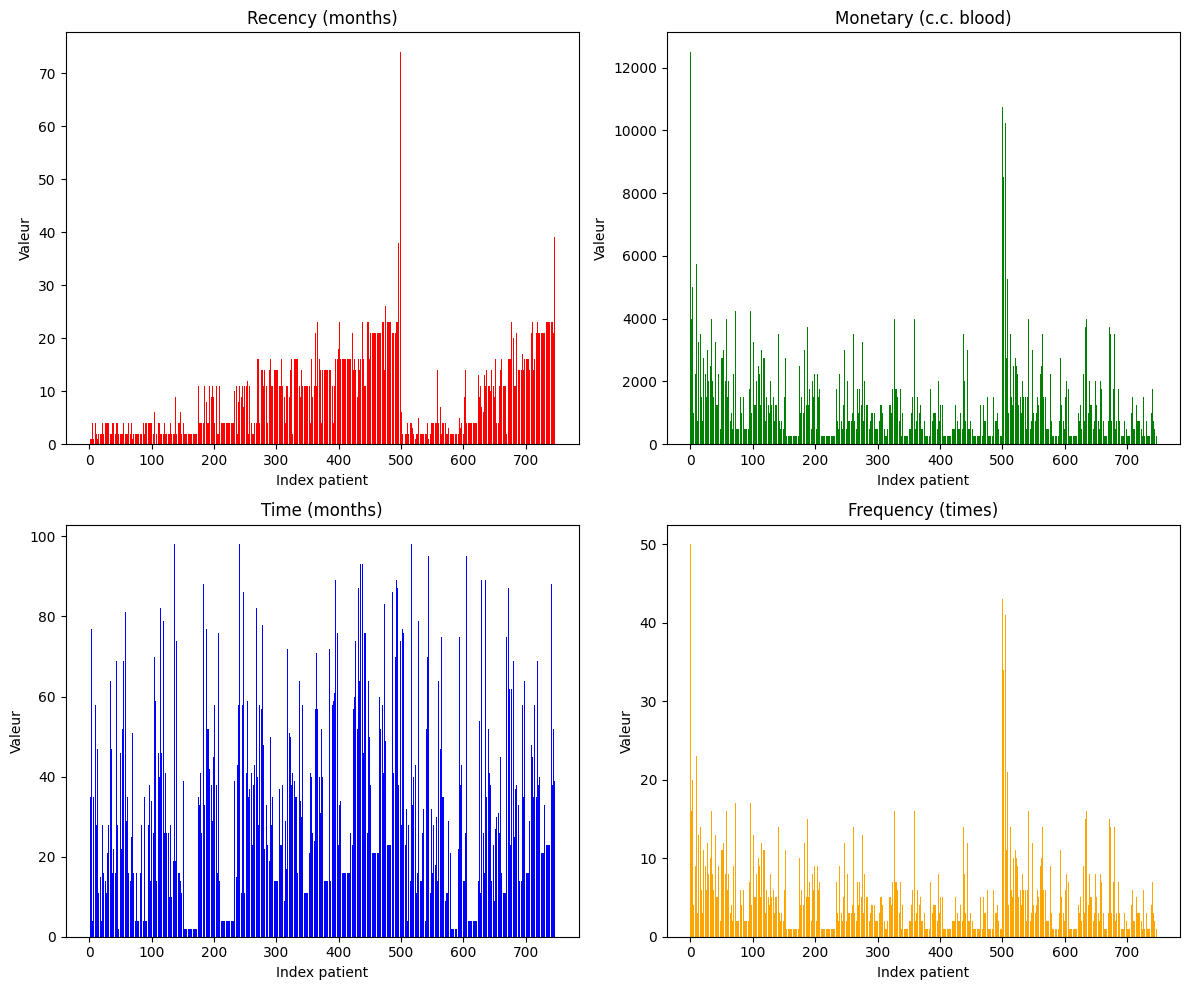

In [9]:
df = pd.read_csv('transfusion.csv')

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

colonnes = [
    'Recency (months)',
    'Monetary (c.c. blood)',
    'Time (months)',
    'Frequency (times)'
]

colors=['red', 'green', 'blue', 'orange']
for idx, col in enumerate(colonnes):
    row, col_pos = idx // 2, idx % 2
    axes[row, col_pos].bar(range(len(df)), df[col], color=colors[idx])
    axes[row, col_pos].set_title(col)
    axes[row, col_pos].set_xlabel('Index patient')
    axes[row, col_pos].set_ylabel('Valeur')

plt.tight_layout()
plt.show()

# 2. Formulation du problème d'optimisation sous forme QUBO (Quadratic unconstrained binary optimization): 

Notre objectif est de trouver le set de catégories parmis les suivantes: 
-  Frequency : le nombre total de dons effectués par le donneur 
-  Recency : le nombre de mois écoulés depuis le dernier don du sang. 
-  Monetary : le volume total (en centimètres cubes) de sang donné 
-  Time : le nombre de mois écoulés depuis le premier don du sang

permettant de prevoir si au passage du camion en mars 2007 les donneurs ont donnés oui ou non leurs sang. On souhaite éliminer les informations deux à deux redondante. 

Afin d'appliquer le QAOA qui nécessitera un Hamiltonien, on cherche à se ramener à une forme QUBO de formulation du problème d'optimisation. Pour rappel, les problèmes QUBO sont formulés avec la fonction de cout suivante :

$$ C(X) = X^T Q X + c^T X $$

## 2.1. Construction de $X$ :  


Si on doit choisir parmi $n$ features, on note $X=[x_0,x_1,..,x_{n-1}]$ le vecteur décrivant si la feature est prise en compte ou non. Les $x_i$ valent tous $0$ ou $1$, et représentent si la categorie est choisi ou pas.

Exemple : $X=[1,0,0,1]$ veut dire que les features $\textbf{Recency}$ et $\textbf{Time}$ sont prises en compte tandis que les features $\textbf{Frequency}$ et $\textbf{Monetary}$ ne le sont pas.

## 2.2. Fonction à optimiser : 

Il est indiqué dans l'énoncé que nous souhaitons les caractèristiques qui prédisent le mieux le don du sang en mars 2007 et éviter la redondance. Nous appelons $Y=[y_0,y_1,..,y_{n-1}]$.
Nous souhaitons donc maximiser la corrélation (ou l'information mutuelle) entre chaque categorie $i$ et la cible $Y$ tout en minimisant la redondance. 
La fonction d'optimisation peut donc s'écrire comme $$F(X) = \text{R}(X) - \text{P}(X)$$; où $\textbf{R}$ représente la redondance et $\textbf{P}$ la pertinance. En minimisant la fonction d'optimisation $\textbf{F}$, ou pourra trouver une solution à notre problème. 

In [14]:
recency = df["Recency (months)"].to_numpy()
frequency = df['Frequency (times)'].to_numpy()
monetary = df['Monetary (c.c. blood)'].to_numpy()
time = df['Time (months)'].to_numpy()

features = [recency, frequency, monetary, time]
Y = df['whether he/she donated blood in March 2007'].to_numpy()

## 2.2. Définition de la matrice de redondance : 

Il s'agit maintenant d'établir un modèle permettant de mesurer la redondance des informations contenues dans les différentes features. Pour cela, nous utiliserons le coefficient de corrélation linéaire de Bravais-Pearson.

In [122]:
R = np.corrcoef(features)
print(Redondance)

[[ 1.         -0.18274547 -0.18274547  0.16061809]
 [-0.18274547  1.          1.          0.63494027]
 [-0.18274547  1.          1.          0.63494027]
 [ 0.16061809  0.63494027  0.63494027  1.        ]]


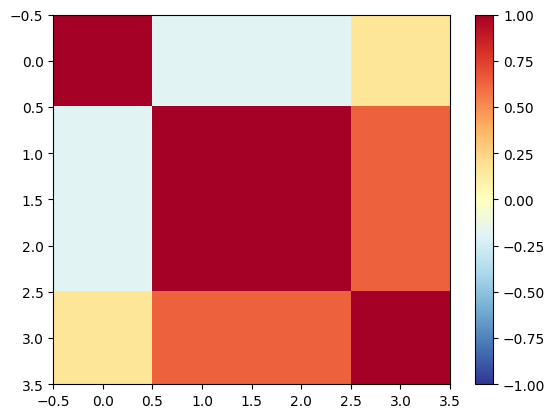

In [123]:
plt.imshow(Redondance,cmap='RdYlBu_r',
                                 aspect='auto',
                                 vmin=-1,
                                 vmax=1,
                                 interpolation='none')
plt.colorbar()

On peut s'apercevoir qu'une feature est fortement corrélée avec elle-même (ce qui est un résultat tout à fait normal), mais nous pouvons également nous rendre compte que les features $\textbf{Monetary}$ et $\textbf{Frequency}$ ont un coefficient de corrélation très élevé, ce qui indique qu'elles transportent des données redondantes vis à vis de l'autre. En effet, il n'y a qu'un coefficient de proportionnalité entre les données de ces deux features. Notre modèle devra donc prendre en compte cette redoncance. 
Ce dernier graphique permet également de déterminer que la feature $\textbf{Recency}$ a un coefficient de corrélation moins élevé avec les deux dernières features que $\textbf{Time}$. 
A ce stade, cette observation est simplement anecdotique et ne sers pas réellement à améliorer notre modèle. 

## 2.2. Définition de la matrice de pertinance : 
Nous voulons à présent représenter la pertinance de chaque features vis à vis des résultats contenues dans $\textbf{Y}$. Nous utilisons donc également le coefficient de corrélation linéaire de Bravais-Pearson. 
La matrice étant symétrique, et sachant qu'une donnée est maximalement corrélée avec elle-même, nous pouvons nous contenter de ne prendre que un des coefficients hors-diagonaux pour enregistrer la mesure de ce coefficient. 

In [124]:
Pertinance = [np.corrcoef(feature, Y) for feature in features]
print(Pertinance)

[array([[ 1.        , -0.27986887],
       [-0.27986887,  1.        ]]), array([[1.        , 0.21863344],
       [0.21863344, 1.        ]]), array([[1.        , 0.21863344],
       [0.21863344, 1.        ]]), array([[ 1.        , -0.03585441],
       [-0.03585441,  1.        ]])]


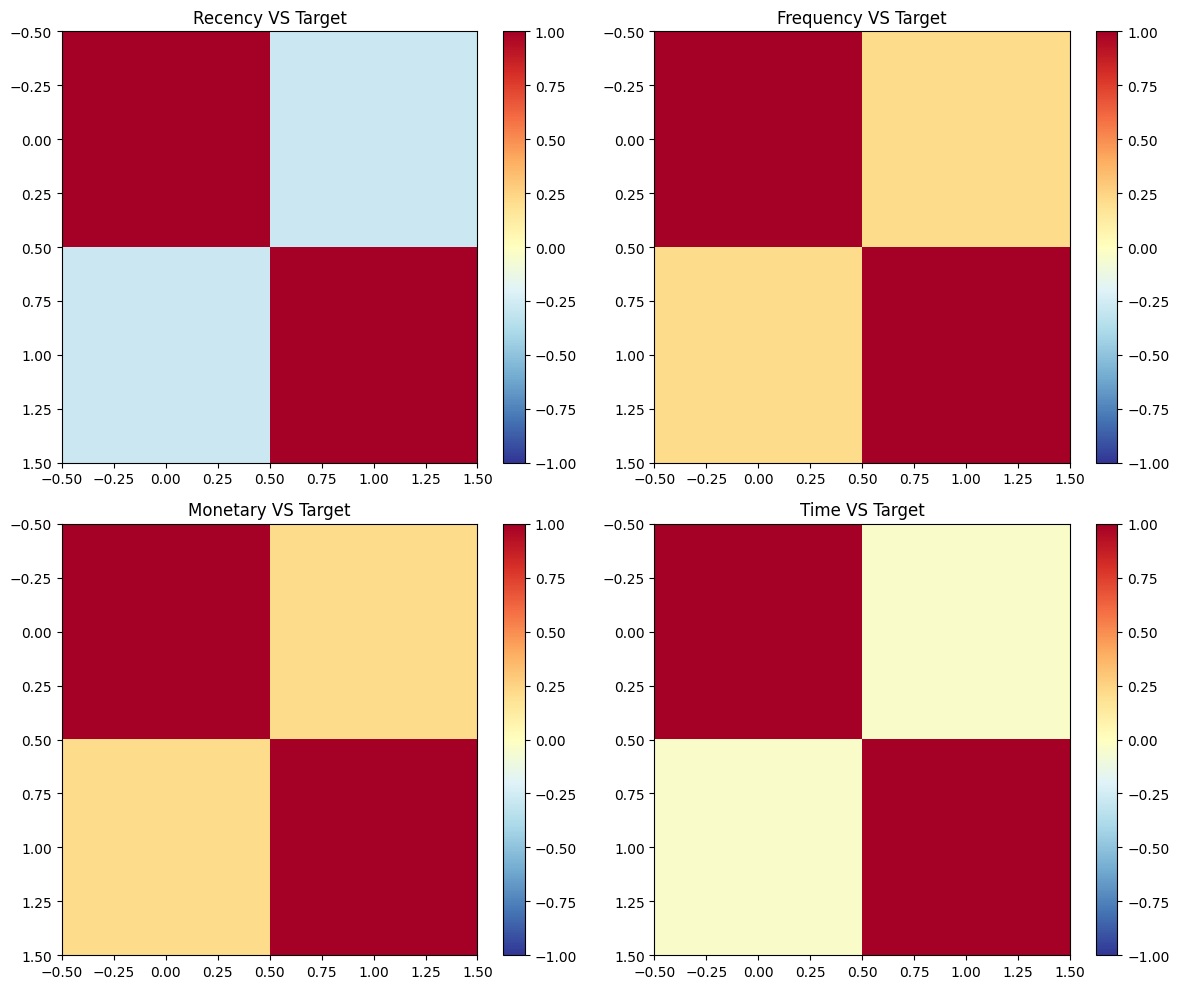

In [125]:
Pertinance = [np.corrcoef(feature, Y) for feature in features]
feature_names = ['Recency', 'Frequency', 'Monetary', 'Time']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, pert in enumerate(Pertinance):
    row, col_pos = idx // 2, idx % 2
    im = axes[row, col_pos].imshow(pert, 
                                 cmap='RdYlBu_r',
                                 aspect='auto',
                                 vmin=-1,
                                 vmax=1,
                                 interpolation='none')
    
    fig.colorbar(im, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(feature_names[idx] + ' VS Target')

plt.tight_layout()
plt.show()

On s'aperçoit que les matrices sont symétriques, et que les seuls valeurs utiles sont les coefficients hors diagonaux. On se propose donc de ne garder que ces derniers dans Pertinance:

In [127]:
P = [np.corrcoef(feature, Y)[0][1] for feature in features]

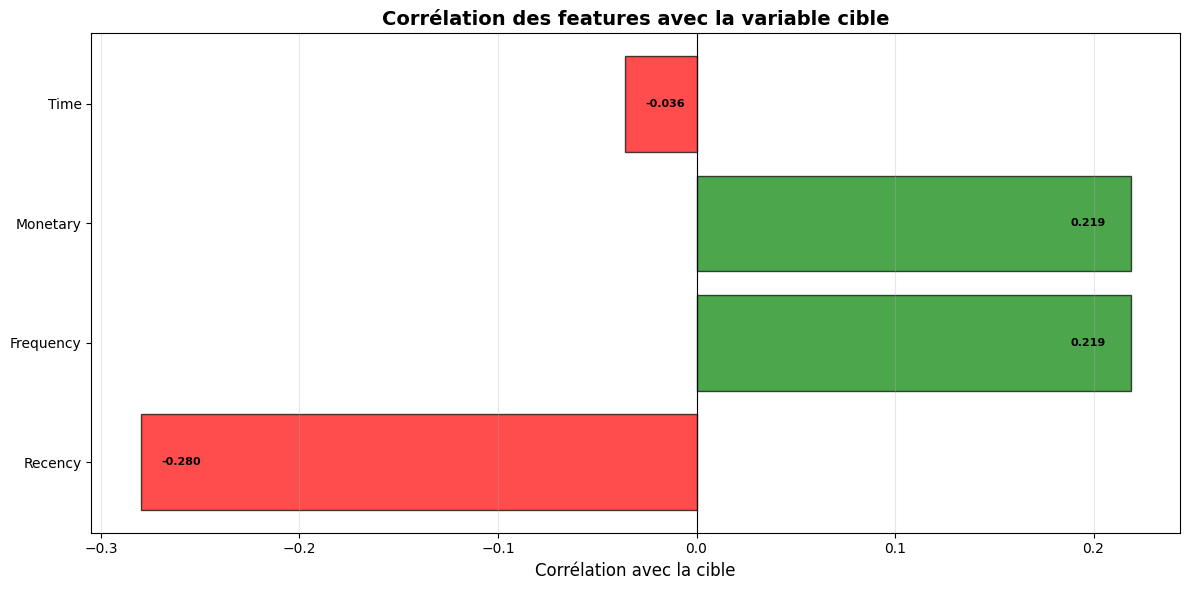

In [128]:
# Créer des couleurs selon le signe
colors = ['red' if x < 0 else 'green' for x in P]

plt.figure(figsize=(12, 6))
bars = plt.barh(feature_names, P, color=colors, alpha=0.7, edgecolor='black')

# Ajouter les valeurs sur les barres
for idx, (bar, val) in enumerate(zip(bars, P)):
    plt.text(val - 0.03 if val > 0 else val + 0.03, idx, 
                 f'{val:.3f}', va='center', ha='left' if val > 0 else 'right',
                 fontweight='bold',
                 fontsize=8)

plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.xlabel('Corrélation avec la cible', fontsize=12)
plt.title('Corrélation des features avec la variable cible', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 2.3 Interprétations des corrélations :
Ces graphiques montrent que la Pertinance de chaque feature vis à vis des résultats contenus dans $\textbf{Y}$. On peut alors voir que la pertinance des features $\textbf{Monetary}$ et $\textbf{Frequency}$ sont les mêmes, ce qui concordent avec le résultat précédent démontrant que ces données sont redondantes. De plus, nous pouvons déduire un ordre de pertiance des features avec les résultats : 
- Frequency / Monetary (Corrélation positive modérée)
- Time (Corrélation négative, faible voire quasi nulle)
- Recency (Corrélation négative modérée)

## 3 - Brut Force

In [ ]:
def get_criterion(x: np.ndarray, R: np.ndarray, P : np.ndarray):
   return np.dot(x.T, np.dot(sigma, x)) - np.dot(mu, x)